This script is for testing extraction of PRISM/Gridmet data to python, which will be used to repeat model evaluation experiments.

In [1]:
import netCDF4 as nc #installed using:conda install netcdf4
import numpy as np
import os
import matplotlib.pyplot as plt
import conda
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr
from datetime import datetime
import glob
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


In [4]:
## Load rain
model_directory = '/GRIDMET/'
pr_dir = model_directory+'GRIDMET_pr_19792023.nc'
pr = xr.open_dataset(pr_dir)
prval = pr.precipitation_amount
prval = prval.sel(day=slice('1981-01', '2010-12'))

In [5]:
## load wind, 
vs_file = model_directory+'GRIDMET_vs_19792020.nc'
vs = xr.open_dataset(vs_file)
vsval = vs.wind_speed
vsval = vsval.sel(day=slice('1981-01', '2010-12'))

## Calculate rain and wind onset

In [6]:
# limit time period to summer
# limit year time
months = [7,8,9,10,11,12]
time_index = [i for i, month in enumerate(prval.day.dt.month) if month in months]
pr_vals = prval.isel(day = time_index)
pr_vals = pr_vals.rename({'day':'time'})

In [7]:
# calculate wind percentile
testing_percentile = .95
UV = vsval
wind_prctiles = UV.quantile(testing_percentile,dim="day")
months = [8,9,10,11,12]
time_index = [i for i, month in enumerate(UV.day.dt.month) if month in months]
UV = UV.isel(day = time_index)

# find where wind exceeds the percentile
wd = xr.where(UV > wind_prctiles,1,0)
wd = wd.rename({'day':'time'})

In [8]:
# empty variables to add data to
fire_weather = []
all_first_wd= []
all_first_wet = []
for i in range(len(wd.groupby('time.year'))):
    # calculate 1 year at a time
    testyear = 1981+i
    # select wind exceedance binary for that year
    wd_testing_year = wd.sel(time=wd.time.dt.year.isin([testyear]))
    # first wind date
    first_wd = wd_testing_year.argmax('time')
    # find grid cells where there is never wind
    all_zeroes = (wd_testing_year==0).all(dim='time')
    # turn those grid cells into nan (if they are 0 it will show as an early wind)
    # you could change it to a max value, like 121 or something, under the assumption that if wind doesn't happen 
    # aug-dec, it happens "late", but this would be creating data. Turning it into nans just ignores those dates
    new_first_wd = xr.where(all_zeroes,np.nan,first_wd)
    # add first wind dates to the array
    all_first_wd.append(new_first_wd)   
    
    
    # rain
    # Select the precipitation data for the testing year
    prcp_year = pr_vals.sel(time=pr_vals.time.dt.year.isin([testyear]))
    # gotta include july, then cut it out
    fall_prcp = prcp_year.sel(time=prcp_year['time.month'] >= 7)
    fall_prcp = fall_prcp.sel(time=fall_prcp['time.month'] < 12)
    # Select the 2-week periods
    fall_prcp_rolling_back = fall_prcp.rolling(time=14).sum(dim='time').fillna(0)
    # limit to august forward
    months = [8,9,10,11,12]
    time_index = [i for i, month in enumerate(fall_prcp_rolling_back.time.dt.month) if month in months]
    fall_prcp_rolling_back = fall_prcp_rolling_back.isel(time = time_index)
    
    fall_prcp_rolling_forward = fall_prcp.rolling(time=14,min_periods=1).sum(dim='time').fillna(0)
    time_index = [i for i, month in enumerate(fall_prcp_rolling_forward.time.dt.month) if month in months]
    fall_prcp_rolling_forward = fall_prcp_rolling_forward.isel(time = time_index)
    # back rolling above 12mm
    new_wet_cond = fall_prcp_rolling_back > 12
 
    # forward rolling under 12
    dry_spell = fall_prcp_rolling_forward < 12
 
    wet_cond_without_dry = new_wet_cond.where(~dry_spell).fillna(0)
 
    first_wet_week = wet_cond_without_dry.argmax('time')
    all_zeroes = (wet_cond_without_dry==0).all(dim='time')
    first_wet_week = xr.where(all_zeroes,np.nan,first_wet_week)
    all_first_wet.append(first_wet_week)

first_wet_hist = xr.concat(all_first_wet,dim='newyear')
first_wind_hist = xr.concat(all_first_wd,dim='newyear')

In [ ]:
# Save the files
wet_file = '/GRIDMET_1981_2010_first_wet_nans_dry_spell.nc'
first_wet_hist.to_netcdf(wet_file)
wind_file= '/GRIDMET_1981_2010_first_wind_nans.nc'
first_wind_hist.to_netcdf(wind_file)

In [2]:
# Load data

first_wet_hist = xr.open_dataset('/GRIDMET_1981_2010_first_wet_nans_dry_spell.nc')
first_wind_hist = xr.open_dataset('/GRIDMET_1981_2010_first_wind_nans.nc')

In [3]:
# Custom colormap for rain onset
import matplotlib.colors
twelve_color_cmap3 = matplotlib.colors.ListedColormap(["snow","lemonchiffon","lightcoral","lightsalmon","gold",
                                                                   "palegreen","mediumseagreen","seagreen",
                                                                   "cornflowerblue","royalblue","slateblue"])

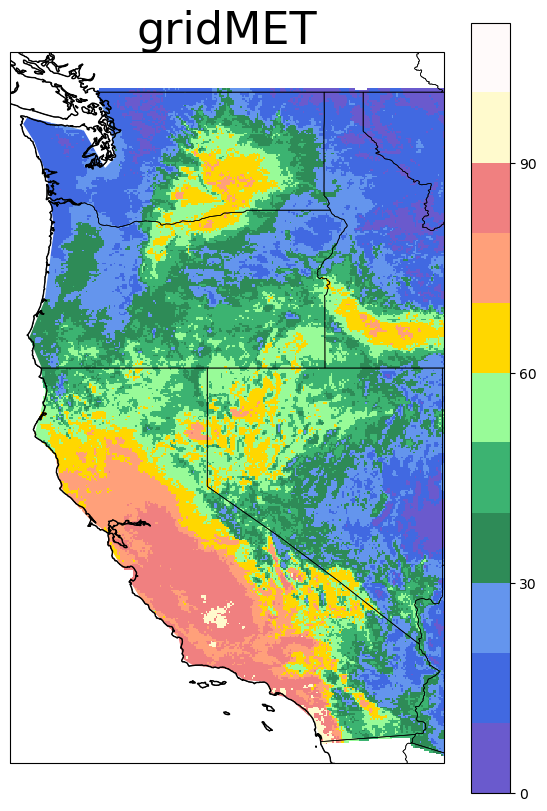

In [4]:
# plotting rain onset
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.ticker import MultipleLocator
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER


gridmet_wet_mean = first_wet_hist.mean(dim='newyear')

fig = plt.figure(1, figsize=[7, 10])
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
#im = plt.pcolormesh(coords['lon2d'], coords['lat2d'], era5_wet_mean.values,cmap=twelve_color_cmap3.reversed(),vmin=0, vmax=110)
im = gridmet_wet_mean.__xarray_dataarray_variable__.plot.pcolormesh(ax=ax, cmap=twelve_color_cmap3.reversed(),vmin=0, vmax=110,add_colorbar=False)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '110m', edgecolor='face', facecolor='white')
ax.add_feature(ocean)
ax.coastlines()
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
ax.set_ylim(32, 50)
ax.set_xlim(-125, -114)
cbar = plt.colorbar(im)
tick_spacing = 30
cbar.locator = MultipleLocator(base=tick_spacing)
cbar.update_ticks()
plt.title('gridMET',fontsize=32)

plt.show()

In [8]:
five_color_cmap = matplotlib.colors.ListedColormap(["lightcoral","gold","mediumseagreen","royalblue"])

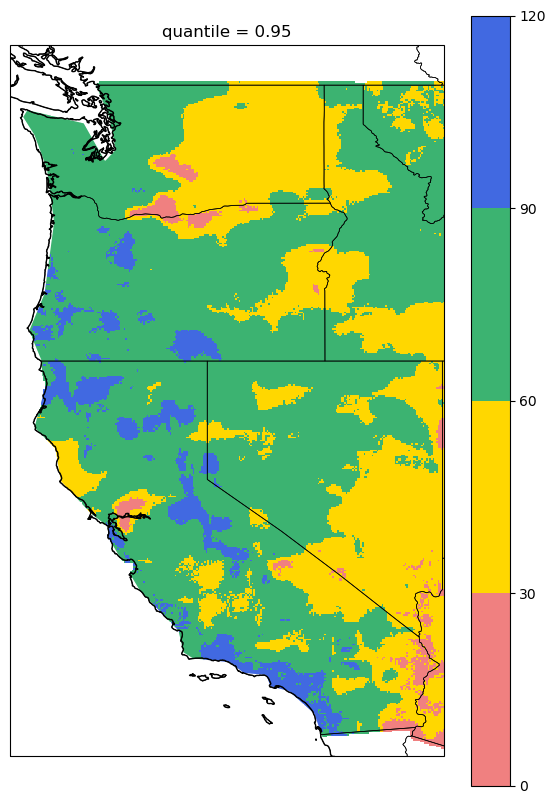

In [11]:
# plotting wind onset

five_color_cmap = matplotlib.colors.ListedColormap(["lightcoral","gold","mediumseagreen","royalblue"])
gridmet_wind_mean = first_wind_hist.mean(dim='newyear')

fig = plt.figure(1, figsize=[7, 10])
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
#im = plt.pcolormesh(coords['lon2d'], coords['lat2d'], era5_wet_mean.values,cmap=twelve_color_cmap3.reversed(),vmin=0, vmax=110)
im = gridmet_wind_mean.wind_speed.plot.pcolormesh(ax=ax, cmap=five_color_cmap,vmin=0, vmax=120,add_colorbar=False)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '110m', edgecolor='face', facecolor='white')
ax.add_feature(ocean)
ax.coastlines()
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
ax.set_ylim(32, 50)
ax.set_xlim(-125, -114)
cbar = plt.colorbar(im)
tick_spacing = 30
cbar.locator = MultipleLocator(base=tick_spacing)
cbar.update_ticks()

## GRIDMET Dry Wind Likelihood

In [16]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import cftime
import pandas as pd
import cftime
import numpy as np
import netCDF4
import os
import cartopy.feature as cfeature
import scipy.stats as stats
from netCDF4 import Dataset
import h5py

In [17]:
## Load rain
model_directory = '/GRIDMET/'
pr_dir = model_directory+'GRIDMET_pr_19792023.nc'
pr = xr.open_dataset(pr_dir)
prval = pr.precipitation_amount
prval = prval.sel(day=slice('1981-01', '2010-12'))

## load wind, 
vs_file = model_directory+'GRIDMET_vs_19792020.nc'
vs = xr.open_dataset(vs_file)
vsval = vs.wind_speed
vsval = vsval.sel(day=slice('1981-01', '2010-12'))

In [ ]:
sfcWind_vals = vsval
pr_vals = prval

# calculating wind percentiles based on one year might cause issues, you need the entire dataset

testing_percentile = .95

months = [7,8,9,10,11]
time_index = [i for i, month in enumerate(pr_vals.day.dt.month) if month in months]
new_dataset = pr_vals.isel(day = time_index)
window = 14
shifted = new_dataset.rolling(day=window,center=False).construct("window")
trailprtotal = shifted.sum(dim='window')

months = [8,9,10,11]
time_index = [i for i, month in enumerate(trailprtotal.day.dt.month) if month in months]
trailprtotal = trailprtotal.isel(day = time_index)

UV = sfcWind_vals
wind_prctiles = UV.quantile(testing_percentile,dim="day")

# find cooccurence of strong wind and dry conditions
# make sure the time periods are the same
months = [8,9,10,11]
time_index = [i for i, month in enumerate(UV.day.dt.month) if month in months]
UV = UV.isel(day = time_index)

wd = xr.where(UV > wind_prctiles,1,0)

drycond = xr.where(trailprtotal < 12,1,0)
wetcond = xr.where(trailprtotal >= 12,1,0)

wd = wd.rename({'day':'time'})
drycond = drycond.rename({'day':'time'})
wetcond = wetcond.rename({'day':'time'})

In [ ]:
hist_fire_occurences = []
total_wind_occurences = []
for i in range(len(wd.groupby('time.year'))):
    testyear = 1981+i
    wd_testing_year = wd.sel(time=wd.time.dt.year.isin([testyear]))
    drycond_testing_year = drycond.sel(time=drycond.time.dt.year.isin([testyear]))

    # Initialize an array of zeros with dimensions of latitude and longitude
    result = np.zeros_like(wd_testing_year.isel(time=0))

    result2 = np.zeros_like(wd_testing_year.isel(time=0))

    for time_index in range(len(wd_testing_year.time)):
        # Get the time slice for both wd_testing_year and drycond_testing_year
        wd_slice = wd_testing_year.isel(time=time_index)
        drycond_slice = drycond_testing_year.isel(time=time_index)

        # Check where both arrays are equal to 1
        mask = (wd_slice == 1) & (drycond_slice == 1)
    
        # count total dry wind
    
        dry_wind = wd_slice == 1

        # Count the number of occurrences where the mask is True and increment the result array
        result += mask
    
        result2 += dry_wind
    # Convert the result array to an xarray DataArray
    result_dataarray = xr.DataArray(result, coords={"lat2d": wd_testing_year.lat2d, "lon2d": wd_testing_year.lon2d}, dims=("lat2d", "lon2d"))
    dw_array = xr.DataArray(result2, coords={"lat2d": wd_testing_year.lat2d, "lon2d": wd_testing_year.lon2d}, dims=("lat2d", "lon2d"))
    hist_fire_occurences.append(result_dataarray)
    total_wind_occurences.append(dw_array)
hist_fire_occurences = xr.concat(hist_fire_occurences,dim='newyear')
hist_fire_occurences_mean = hist_fire_occurences.mean(dim='newyear')

hist_wind_occurence = xr.concat(total_wind_occurences,dim='newyear')


In [15]:
# load data

model_directory = '/GRIDMET/'
gridmet_file = model_directory+'/era5/GRIDMET_1981_2010_95_total_occurence.nc'
fw_dataset = xr.open_dataset(gridmet_file)
total_wind = fw_dataset.total_wind.sum(dim='newyear')
dry_wind = fw_dataset.dry_wind_total.sum(dim='newyear')
proportion_GRIDMET = dry_wind/total_wind

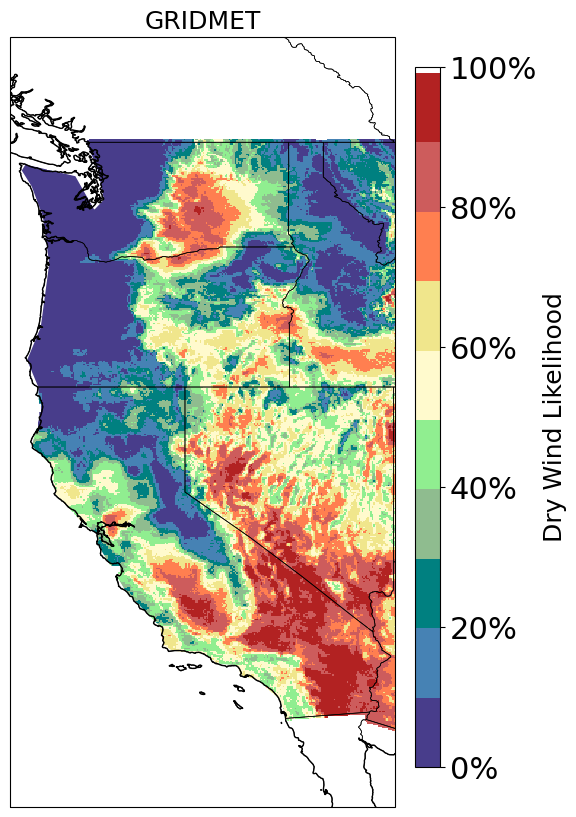

In [19]:
# plotting
# Build some custom colormaps
import matplotlib.colors

segment_map_new = matplotlib.colors.ListedColormap(["darkslateblue","steelblue","teal","darkseagreen","lightgreen","lemonchiffon","khaki","coral","indianred","firebrick"])


# plot historical pr
fig = plt.figure(figsize=[10,10])
ax = plt.subplot(1,1,1,projection = ccrs.PlateCarree())
#im = plt.pcolormesh(coords['lon2d'],coords['lat2d'],proportion_era5,cmap=segment_map_new)
im = proportion_GRIDMET.plot.pcolormesh(ax=ax, cmap=segment_map_new,add_colorbar=False)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '110m', edgecolor='face', facecolor='white')
ax.add_feature(ocean)
#plt.colorbar(im)
#plt.pcolormesh(nds['lon2d'],nds['lat2d'],nds['wspd10mean'].isel(day=1))
ax.coastlines()
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=.5)
ax.set_ylim(30,52)
ax.set_xlim(-125,-114)
plt.title('GRIDMET',fontsize=18)
#plt.title('Likelihood of Fall Dry Conditions and Strong Wind \n (ERA5 1981-2010)',fontsize=10)
cbar_ax = fig.add_axes([0.725, 0.15, 0.025, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
new_ticks = np.linspace(0, 1, 6)  # Adjust the number of ticks as needed
new_tick_labels = [f'{int(t*100)}%' for t in new_ticks]

cbar.set_ticks(new_ticks)
cbar.set_ticklabels(new_tick_labels)
cbar.ax.tick_params(labelsize=22) 
cbar.set_label('Dry Wind Likelihood', rotation=90,fontsize=18)